<a href="https://colab.research.google.com/github/kiskapitalis/MVbeadando/blob/master/Measuring_the_Abstraction_Capabilities_of_Image_Recognition_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Define the model we want to examine
# By default we examine a simple image recognition neural network

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import AveragePooling2D

def build_examined_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [3]:
# Create all the neccessary objects and helper functions to run the tests 

import copy
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils

class Shape:

    _frame_size = 28
    _shape_size = 15
    _vertical_middle_line = 14
    _horizontal_middle_line = 14
    _diagonals = False
    _noiseLevel = 0

    def __init__(self, index, horizontal_bool, vertical_bool):
        self._index = index
        self._horizontal_bool = horizontal_bool
        self._vertical_bool = vertical_bool

    def toMatrix(self):
        self._horizontal_positions = [self._horizontal_middle_line - self._shape_size // 2,
                                      self._horizontal_middle_line,
                                      self._horizontal_middle_line + self._shape_size // 2]
        self._vertical_positions = [self._vertical_middle_line - self._shape_size // 2,
                                    self._vertical_middle_line,
                                    self._vertical_middle_line + self._shape_size // 2]
        matrix = np.zeros(shape=(28,28)).astype(int)
        for x in range(3):
            matrix = self.drawHorizontalLine(matrix, x)
            matrix = self.drawVerticalLine(matrix, x)
        if self._diagonals:
            matrix = self.addDiagonals(matrix)
        return self.addNoise(matrix)

    def toArray(self):
        matrix = self.toMatrix()
        return matrix.flatten()

    def drawOut(self):
        matrix = self.toMatrix()
        plt.matshow(matrix)

    def drawHorizontalLine(self, output, x):
        if self._horizontal_bool[x]:
            output[self._horizontal_positions[x]] = self.drawLine(self._vertical_positions)
        return output

    def drawVerticalLine(self, output, x):
        if self._vertical_bool[x]:
            output[:, self._vertical_positions[x]] = self.drawLine(self._horizontal_positions)
        return output

    def drawLine(self, positions):
        return [0] * (positions[0]) + \
               [9] * (positions[2] - positions[0] + 1) + \
               [0] * (self._frame_size - positions[2] - 1)

    def getIndex(self):
        return self._index

    def resize(self, size):
        self._shape_size = size

    def move(self, horizontal_start_pos, vertical_start_pos):
        self._horizontal_middle_line = horizontal_start_pos
        self._vertical_middle_line = vertical_start_pos

    def rotate(self):
        new_vertical_bool = np.flip(self._horizontal_bool)
        self._horizontal_bool = self._vertical_bool
        self._vertical_bool = new_vertical_bool

    def flip(self):
        self._horizontal_bool = np.flip(self._horizontal_bool)
  
    def setDiagonals(self):
        self._diagonals = True  

    def setNoiseLevel(self, noiseLevel):
        self._noiseLevel = noiseLevel

    def randomResize(self):
        random_number = random.randint(5, 27)
        self._shape_size = random_number

    def randomMove(self):
        self._horizontal_middle_line = random.randint(7, 20)
        self._vertical_middle_line = random.randint(7, 20)

    def randomRotate(self):
        number_of_rotate = random.randint(0, 3)
        for _ in range (number_of_rotate):
            self.rotate()

    def addDiagonals(self, matrix):
        for i in range(self._frame_size):
            j = self._frame_size - i - 1
            matrix[i][i] = 9
            matrix[i][j] = 9
        return matrix

    def addNoise(self, matrix):
        mean = 0.0   # some constant
        std = self._noiseLevel
        noisy_matrix = matrix + np.random.normal(mean, std, matrix.shape)
        return np.clip(noisy_matrix, 0, 10)  # we might get out of bounds due to noise

class SetOfShapes:

    zero = Shape(0, [True, False, False], [True, False, False])
    one = Shape(1, [True, False, False], [False, True, False])
    two = Shape(2, [True, False, False], [True, True, False])
    three = Shape(3, [True, False, False], [True, False, True])
    four = Shape(4, [True, False, False], [True, True, True])
    five = Shape(5, [True, True, False], [True, False, False])
    six = Shape(6, [True, True, False], [False, True, False])
    seven = Shape(7, [True, True, False], [True, True, False])
    eight = Shape(8, [True, True, False], [True, False, True])
    nine = Shape(9, [True, True, False], [True, True, True])

    original_shapes = [zero, one, two, three, four, five, six, seven, eight, nine]

    def __init__(self, size, start=0, end=10):
        size = int(size)
        self._shapes = np.empty(size,dtype=Shape)
        shapes_to_work_with = self.original_shapes[start:end+1]
        number_of_shapes = len(shapes_to_work_with)
        # print(number_of_shapes)
        for x in range(size):
            shape = shapes_to_work_with[x % number_of_shapes]
            self._shapes[x] = copy.deepcopy(shape)

    def showPicture(self, number):
        self._shapes[number].drawOut()

    def doTransformation(self, transformation):
        if transformation == "Rotated":  
            self.randomRotate()
        elif transformation == "Moved":
            self.randomMove()
        elif transformation == "Resized":
            self.randomResize()
        elif transformation == "Diagonals":
            self.addDiagonals()
        elif transformation == "Mirroring":
            self.flip()
        return self

    def randomResize(self):
        for shape in self._shapes:
            shape.randomResize()
        return self

    def randomMove(self):
        for shape in self._shapes:
            shape.randomMove()
        return self

    def randomRotate(self):
        for shape in self._shapes:
            shape.randomRotate()
        return self

    def flip(self):
        for shape in self._shapes:
            shape.flip()
        return self

    def addNoise(self, noiseLevel):
        for shape in self._shapes:
            shape.setNoiseLevel(noiseLevel)
        return self

    def addDiagonals(self):
        for shape in self._shapes:
            shape.setDiagonals()
        return self

    def getShapes(self):
        return self._shapes

    def addSetOfShapes(self, setOfShapes):
        self._shapes = np.append(self._shapes, setOfShapes.getShapes())

    def addShapes(self, shapes):
        self._shapes = np.append(self._shapes, shapes)

    def generate_X_values(self):
        X_values = np.zeros(shape=(self._shapes.size, 784))
        for idx, shape in np.ndenumerate(self._shapes):
            X_values[idx] = shape.toArray()
        return X_values

    def generate_Y_values(self):
        Y_values = np.zeros(shape=(self._shapes.size))
        for idx, shape in np.ndenumerate(self._shapes):
            Y_values[idx] = shape.getIndex()
        return Y_values

    def split(self, number_of_parts):
        setOfShapes = np.empty(number_of_parts,dtype=SetOfShapes)
        size_of_one_part = len(self._shapes) / number_of_parts
        for x in range(number_of_parts):
            start = int(x * size_of_one_part)
            end = int((x + 1) * size_of_one_part)
            setOfShapes[x] = SetOfShapes(0)
            setOfShapes[x].addShapes(self._shapes[start:end])
        return setOfShapes

    def merge(set_of_shapes_array):
        merged_set_of_shapes = SetOfShapes(0)
        for set_of_shapes in set_of_shapes_array:
            merged_set_of_shapes.addSetOfShapes(set_of_shapes)
        return merged_set_of_shapes

def testSets(name, trainShapes, testShapes, model):
    print("Evaluation of " + name)
    # generate X and Y values to analyze
    Y_train = trainShapes.generate_Y_values()
    X_train = trainShapes.generate_X_values()
    Y_test = testShapes.generate_Y_values()
    X_test = testShapes.generate_X_values()
    # reshape to be [samples][width][height][channels]
    X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('int')
    X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('int')
    # normalize inputs from 0-255 to 0-1
    X_train = X_train / 9
    X_test = X_test / 9
    # one hot encode outputs
    Y_train = np_utils.to_categorical(Y_train)
    Y_test = np_utils.to_categorical(Y_test)
    num_classes = Y_test.shape[1]
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=200)
    # Final evaluation of the model
    scores = model.evaluate(X_test, Y_test, verbose=0)
    final_score = scores[1]*100
    print("Succes rate on %s: %.2f%%" % (name, final_score))
    return final_score

def testMultipleSets(name, trainShapes, testShapes, model):
    number_of_train_sets = len(trainShapes)
    number_of_test_sets = len(testShapes)
    number_of_tests = max(number_of_train_sets, number_of_test_sets)
    results = np.empty(number_of_tests,dtype=int)
    for x in range(number_of_tests):
        train_set = trainShapes[x % number_of_train_sets]
        print(len(train_set.getShapes()))
        test_set = testShapes[x % number_of_test_sets]
        print(len(test_set.getShapes()))
        results[x] = testSets(name + " (" + str(x+1) + ")", train_set, test_set, build_examined_model())
    output = "Average score on %s: %.2f%% ± %.2f%% \n" % (name, np.average(results), np.std(results))
    print(output)
    raw_output = "%.2f±%.2f" % (np.average(results), np.std(results))
    return raw_output

def testSomeMultipleSets():
    originalSet = SetOfShapes(10)
    hugeSet = SetOfShapes(50)
    hugeSet.randomMove()
    movedSets = hugeSet.split(5)
    mixedSet = SetOfShapes.merge([originalSet, movedSets[0]])
    sameSet = SetOfShapes.merge([movedSets[1], movedSets[2]])
    testSets("merged", mixedSet, sameSet, build_examined_model())
    testMultipleSets("Moved objects", [originalSet], movedSets, build_examined_model())

def testWithDifferentSampleAmountOnOriginalTrain(name, sample_amounts, noise_level):
    output = "\t\t\emph{" + name + "}"
    for number_of_images in sample_amounts:
        output += " & "
        trainSets = SetOfShapes(5*number_of_images).split(5)
        testSets = SetOfShapes(5*number_of_images).doTransformation(name).addNoise(noise_level).split(5)
        output += testMultipleSets(name, trainSets, testSets, build_examined_model())
        output += " \% "
    output += " \\\\\n\t\t\\hline\n"
    return output

def testWithDifferentSampleAmount(name, sample_amounts, noise_level):
    output = "\t\t\emph{" + name + "}"
    for number_of_images in sample_amounts:
        output += " & "
        trainSets = SetOfShapes(5*number_of_images).doTransformation(name).addNoise(noise_level).split(5)
        testSets = SetOfShapes(5*number_of_images).doTransformation(name).addNoise(noise_level).split(5)
        output += testMultipleSets(name, trainSets, testSets, build_examined_model())
        output += " \% "
    output += " \\\\\n\t\t\\hline\n"
    return output

def testWithDifferentSampleAmountWithLimitedAmount(name, sample_amounts, noise_level, limited_amount):
    output = "\t\t\emph{" + name + "}"
    for number_of_images in sample_amounts:
        output += " & "
        trainSets = np.empty(5,dtype=SetOfShapes)
        for x in range(5):
            trained_number = number_of_images * limited_amount / 10
            transformedTrainSet = SetOfShapes(trained_number, 0, limited_amount-1).doTransformation(name).addNoise(noise_level)
            originalTrainSets = SetOfShapes(number_of_images - trained_number, limited_amount, 10).addNoise(noise_level)
            trainSets[x] = SetOfShapes.merge([transformedTrainSet, originalTrainSets])
        testSets = SetOfShapes(5*number_of_images).doTransformation(name).addNoise(noise_level).split(5)
        output += testMultipleSets(name, trainSets, testSets, build_examined_model())
        output += " \% "
    output += " \\\\\n\t\t\\hline\n"
    return output


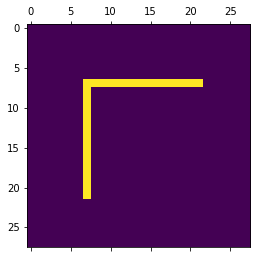

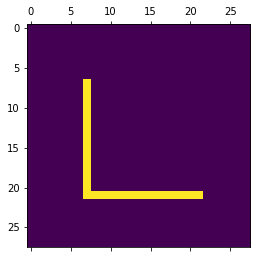

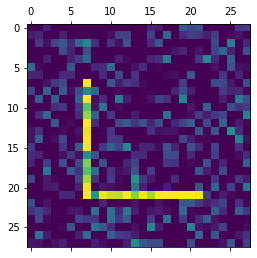

In [4]:
# Draw out some pictures of objects

setOfShapes = SetOfShapes(10)
setOfShapes.showPicture(0)
setOfShapes.flip()
setOfShapes.showPicture(0)
setOfShapes.addNoise(2)
setOfShapes.showPicture(0)

In [5]:
# Example of calculating values and printing them in a structured LaTeX table

from IPython.display import clear_output
np.set_printoptions(threshold=sys.maxsize)

# Number of samples in the train- and testsets
sample_amounts = [1000, 2000, 5000, 10000] 
# Number of transformed objects in the trainset
limited_amount = 8 
# Degree of noiseness in the train- and testsets
noise_level = 4 

output = "\\begin{table}[H]\n\\centering\n\t\\begin{tabular}{ | m{0.13\\textwidth} | m{0.18\\textwidth} | m{0.18\\textwidth} | m{0.18\\textwidth} | m{0.18\\textwidth} |}\n" \
          "\t\t\\hline\n\t\t\\textbf{} & \\textbf{%s} & \\textbf{%s} & \\textbf{%s} & \\textbf{%s} \\\\\n\t\t\\hline \\hline\n" % (sample_amounts[0], sample_amounts[1], sample_amounts[2], sample_amounts[3])

output += testWithDifferentSampleAmountWithLimitedAmount("Rotated", sample_amounts, noise_level, limited_amount)
output += testWithDifferentSampleAmountWithLimitedAmount("Moved", sample_amounts, noise_level, limited_amount)
output += testWithDifferentSampleAmountWithLimitedAmount("Resized", sample_amounts, noise_level, limited_amount)
output += testWithDifferentSampleAmountWithLimitedAmount("Diagonals", sample_amounts, noise_level, limited_amount)
output += testWithDifferentSampleAmountWithLimitedAmount("Mirroring", sample_amounts, noise_level, limited_amount)

output += "\t\\end{tabular}\n\t\\caption{Limited amount: %s Noise level: %s}\n\t\\label{tab:%s-%s}\n\\end{table}" % (limited_amount, noise_level, limited_amount, noise_level)

clear_output()

print(output)

1000
1000
Evaluation of Rotated (1)
Epoch 1/10
5/5 [==============================] - 18s 323ms/step - loss: 2.3001 - accuracy: 0.1053 - val_loss: 2.2809 - val_accuracy: 0.1650
Epoch 2/10
5/5 [==============================] - 1s 168ms/step - loss: 2.2624 - accuracy: 0.2026 - val_loss: 2.2352 - val_accuracy: 0.2400
Epoch 3/10
5/5 [==============================] - 1s 170ms/step - loss: 2.1945 - accuracy: 0.3043 - val_loss: 2.1556 - val_accuracy: 0.2730
Epoch 4/10
5/5 [==============================] - 1s 169ms/step - loss: 2.0628 - accuracy: 0.3638 - val_loss: 2.0355 - val_accuracy: 0.3010
Epoch 5/10
5/5 [==============================] - 1s 169ms/step - loss: 1.8834 - accuracy: 0.4229 - val_loss: 1.8760 - val_accuracy: 0.3330
Epoch 6/10
5/5 [==============================] - 1s 178ms/step - loss: 1.6981 - accuracy: 0.4178 - val_loss: 1.7521 - val_accuracy: 0.4020
Epoch 7/10
5/5 [==============================] - 1s 182ms/step - loss: 1.5037 - accuracy: 0.4635 - val_loss: 1.7250 - val_

KeyboardInterrupt: ignored